<a href="https://colab.research.google.com/github/yankikalfa/MGTF-405-Business-Forecasting/blob/main/Lecture_5_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector Autoregression and Factor Models

In [ ]:
! pip install pymc

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA
import matplotlib.pyplot as plt
import os as os
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from scipy.stats import invwishart, invgamma
import pymc as pm
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

Mounted at /content/drive/


## Vector Autoregression (VAR and Vector Error Correction Models (VECM)

In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [ ]:
macro_df = pd.read_excel('/content/drive/MyDrive/MGTF 405/macro_data.xlsx', parse_dates=True,index_col=0)

### VAR

In [ ]:
adf_test(macro_df['CPI'])

Results of Dickey-Fuller Test:
Test Statistic                   1.637653
p-value                          0.997966
#Lags Used                       5.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


In [ ]:
adf_test(macro_df['DGS10'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.973080
p-value                          0.762956
#Lags Used                       7.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


In [ ]:
adf_test(macro_df['GDPC1'])

Results of Dickey-Fuller Test:
Test Statistic                   1.572335
p-value                          0.997772
#Lags Used                       1.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


In [ ]:
adf_test(macro_df['UNRATE'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.312474
p-value                          0.014330
#Lags Used                       0.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


All variables except the unemployment rate are non-stationary. We will need to get all of our variables to be stationary to work with VARs.

In [ ]:
macro_df['infl'] = np.log(macro_df['CPI']).diff(4)*100
macro_df['gdpyoy'] = np.log(macro_df['GDPC1']).diff(4)*100
macro_df['10yr'] = macro_df['DGS10']
macro_df['unemp']= macro_df['UNRATE']

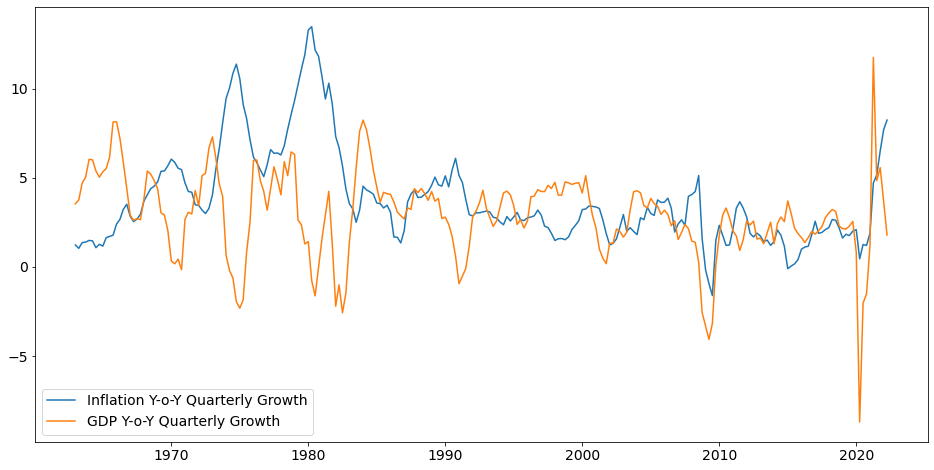

In [ ]:
plt.plot(macro_df['infl'],label='Inflation Y-o-Y Quarterly Growth')
plt.plot(macro_df['gdpyoy'],label='GDP Y-o-Y Quarterly Growth')
plt.legend()

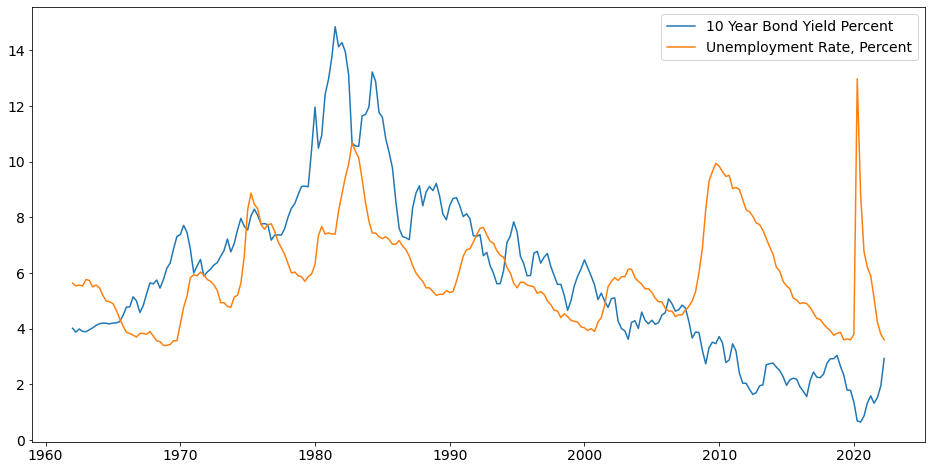

In [ ]:
plt.plot(macro_df['10yr'],label='10 Year Bond Yield Percent')
plt.plot(macro_df['unemp'],label='Unemployment Rate, Percent')
plt.legend()

In [ ]:
macro_df.dropna(inplace=True)
model_data = macro_df[['gdpyoy','infl','10yr','unemp']]
train_data= model_data.iloc[:-20,:]
test_data = model_data.iloc[-20:,:]

In [ ]:
test_data

,gdpyoy,infl,10yr,unemp
date,,,,
2017-07-01,2.251013,1.926267,2.241429,4.333333
2017-10-01,2.755992,2.085874,2.371452,4.166667
2018-01-01,3.017515,2.196699,2.758525,4.033333
2018-04-01,3.209910,2.652131,2.920625,3.933333
2018-07-01,3.105267,2.608834,2.923810,3.766667
2018-10-01,2.286249,2.181066,3.041148,3.833333
2019-01-01,2.137226,1.607181,2.652951,3.866667
2019-04-01,2.113057,1.819152,2.338889,3.600000
2019-07-01,2.279645,1.753867,1.797969,3.633333


In [ ]:
VARmodel = VAR(train_data).fit(maxlags=8, ic='aic')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [ ]:
VARmodel.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Oct, 2022
Time:                     14:58:02
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -4.47879
Nobs:                     211.000    HQIC:                  -5.57665
Log likelihood:          -414.664    FPE:                 0.00180985
AIC:                     -6.32152    Det(Omega_mle):      0.00108125
--------------------------------------------------------------------
Results for equation gdpyoy
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.126952         0.450444            0.282           0.778
L1.gdpyoy         0.977501         0.086436           11.309           0.000
L1.infl          -0.232226         0.121185           -1.916           0.05

In [ ]:
lag_order = VARmodel.k_ar
VAR_forecasts=pd.DataFrame(VARmodel.forecast(train_data.values[-lag_order:],20))

In [ ]:
VAR_forecasts.rename(columns={0:'gdpyoy_f',1:'infl_f',2:'10yr_f',3:'unemp_f'},inplace=True)
test_data_new=pd.concat([test_data.reset_index(),VAR_forecasts],axis=1)
test_data_new.set_index('date',inplace=True)

Text(0.5, 1.0, 'GDP Forecast')

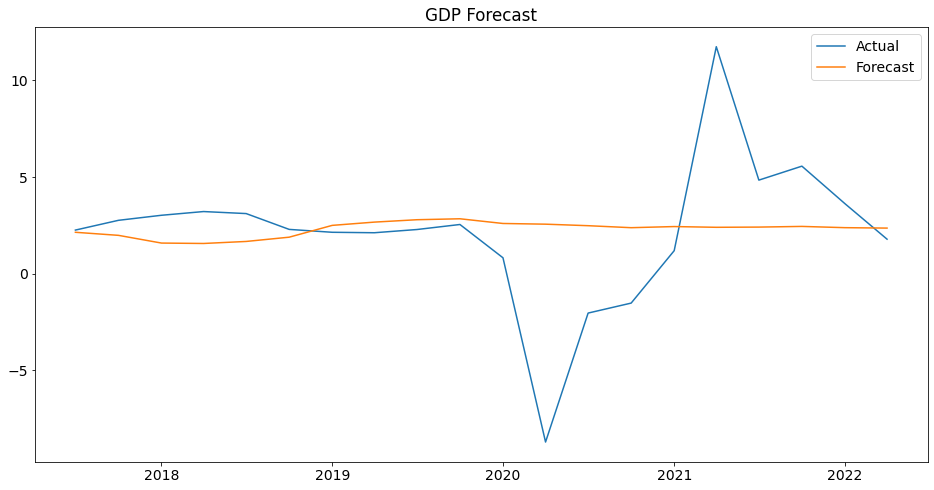

In [ ]:
plt.plot(test_data_new['gdpyoy'],label='Actual')
plt.plot(test_data_new['gdpyoy_f'],label='Forecast')
plt.legend()
plt.title('GDP Forecast')

Text(0.5, 1.0, 'Inflation Forecast')

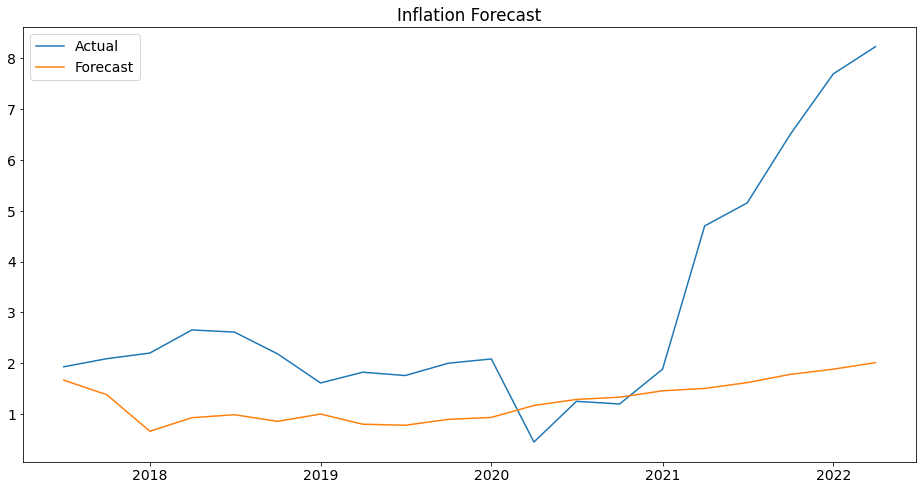

In [ ]:
plt.plot(test_data_new['infl'],label='Actual')
plt.plot(test_data_new['infl_f'],label='Forecast')
plt.legend()
plt.title('Inflation Forecast')

Text(0.5, 1.0, '10 Year Yield Forecast')

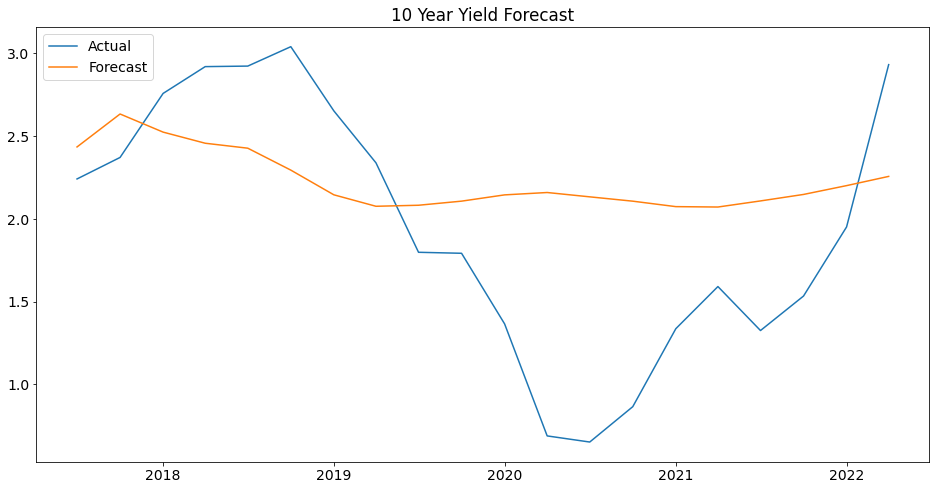

In [ ]:
plt.plot(test_data_new['10yr'],label='Actual')
plt.plot(test_data_new['10yr_f'],label='Forecast')
plt.legend()
plt.title('10 Year Yield Forecast')

Text(0.5, 1.0, 'Unemployment Forecast')

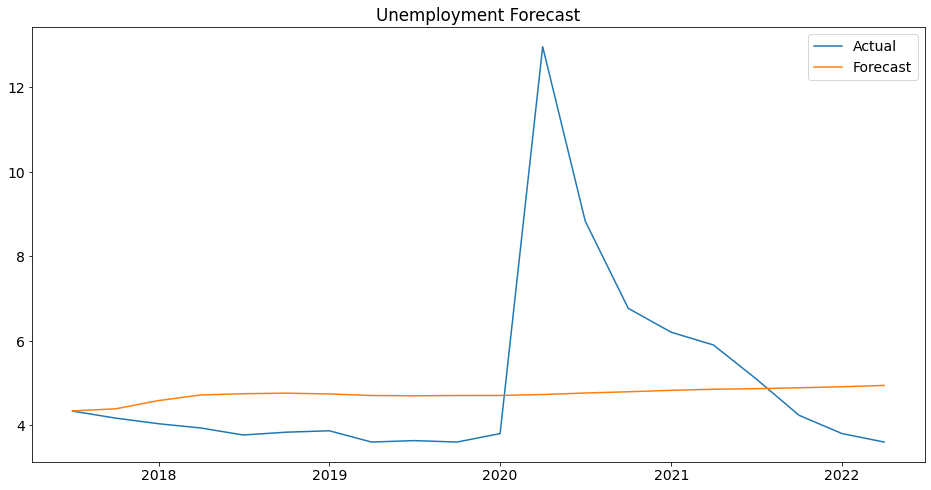

In [ ]:
plt.plot(test_data_new['unemp'],label='Actual')
plt.plot(test_data_new['unemp_f'],label='Forecast')
plt.legend()
plt.title('Unemployment Forecast')

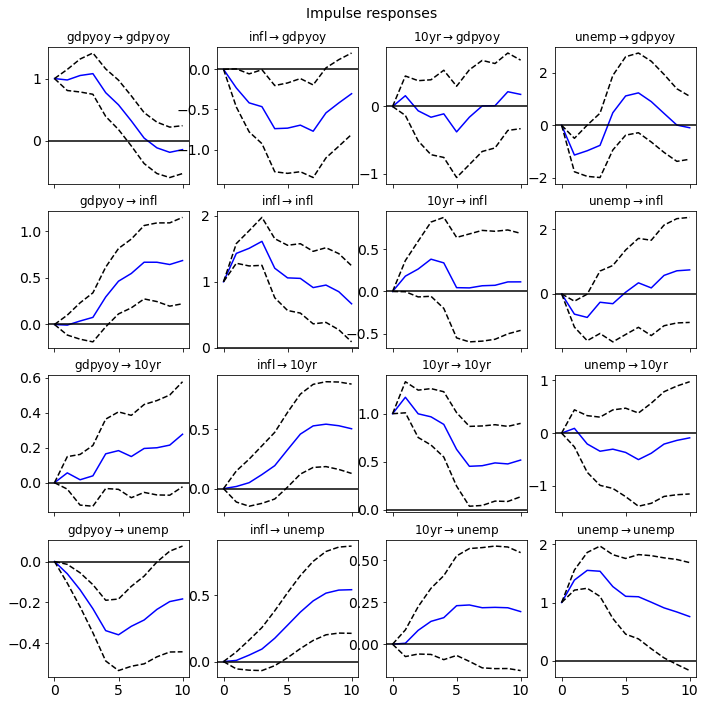

In [ ]:
irf = VARmodel.irf(10)
irf.plot(orth=False)
plt.show()

### VECM

In [ ]:
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import select_order,select_coint_rank
# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
micro_df = pd.read_excel('/content/drive/MyDrive/MGTF 405/microchip.xlsx',parse_dates=True,index_col=0)
micro_df=micro_df.resample('M').last()
micro_df=np.log(micro_df)

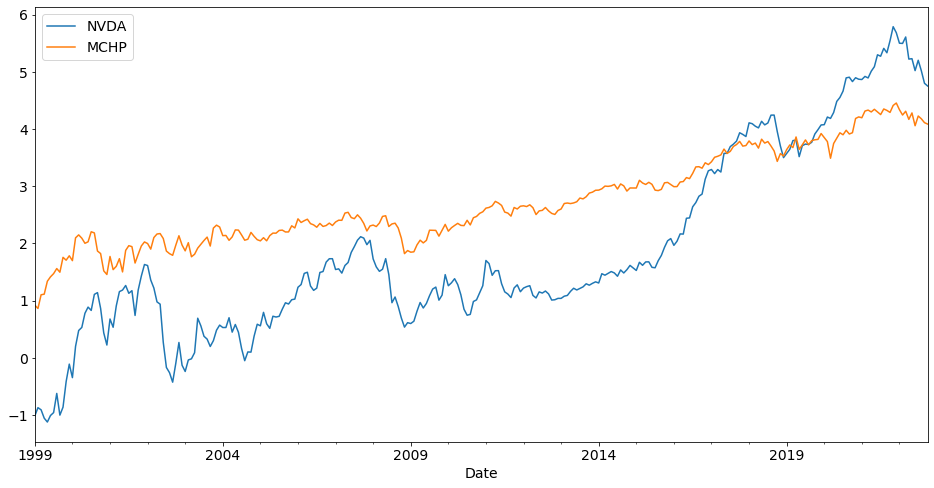

In [ ]:
micro_df.plot()

In [ ]:
lag_order = select_order(data=micro_df, maxlags=36, deterministic="ci")

In [ ]:
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic

(1, 0, 1, 1)

In [ ]:
rank_test = select_coint_rank(micro_df, 0,1, method='trace',
                              signif=0.1)
rank_test.rank

1

In [ ]:
model = VECM(micro_df, deterministic="ci",
             k_ar_diff=lag_order.aic,  
             coint_rank=rank_test.rank).fit()
model.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.NVDA,0.1509,0.068,2.218,0.027,0.018,0.284
L1.MCHP,-0.1137,0.114,-0.999,0.318,-0.337,0.109
,coef,std err,z,P>|z|,[0.025,0.975]
L1.NVDA,-0.0232,0.041,-0.568,0.570,-0.103,0.057
L1.MCHP,-0.1159,0.068,-1.694,0.090,-0.250,0.018
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0325,0.018,-1.766,0.077,-0.069,0.004
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0197,0.011,1.782,0.075,-0.002,0.041
,coef,std err,z,P>|z|,[0.025,0.975]


In [ ]:
micro_df['coint_rel'] = micro_df['NVDA'] - micro_df['MCHP'] * model.beta[1]
micro_df['coint_rel'] = micro_df['coint_rel'] - 4.1311

Text(0.5, 1.0, 'Cointegrating Relationship')

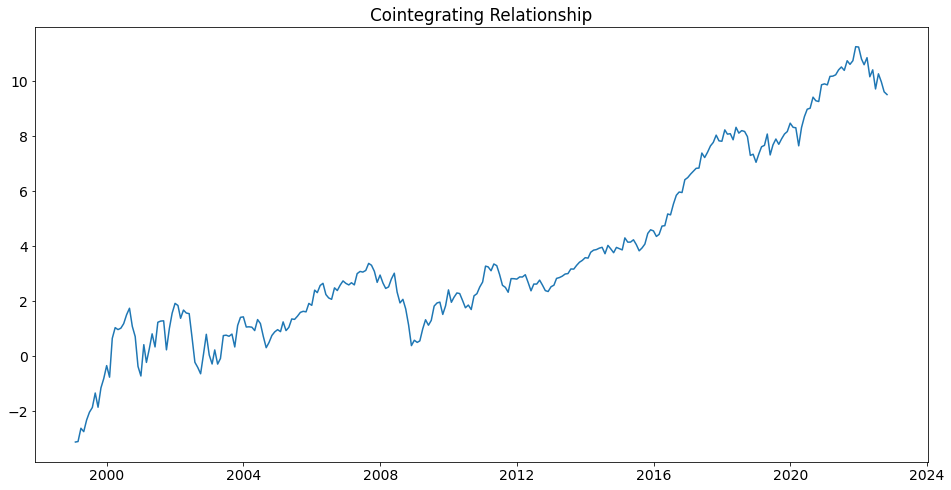

In [ ]:
plt.plot(micro_df['coint_rel'])
plt.title('Cointegrating Relationship')


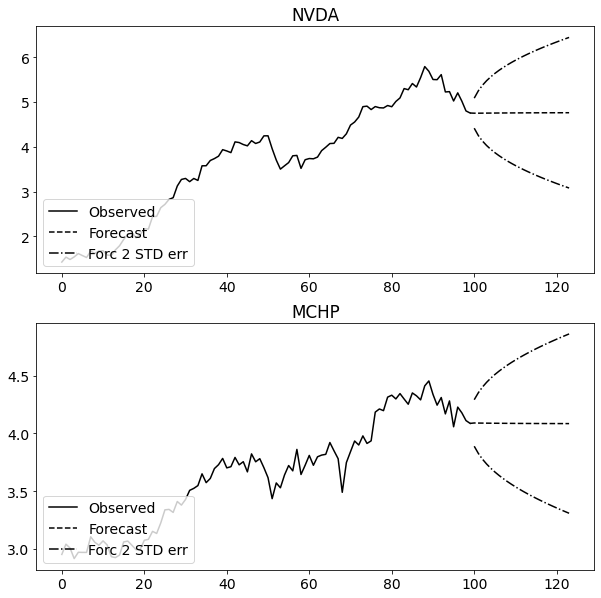

In [ ]:
model.plot_forecast(steps=24, plot_conf_int=True, n_last_obs=100)

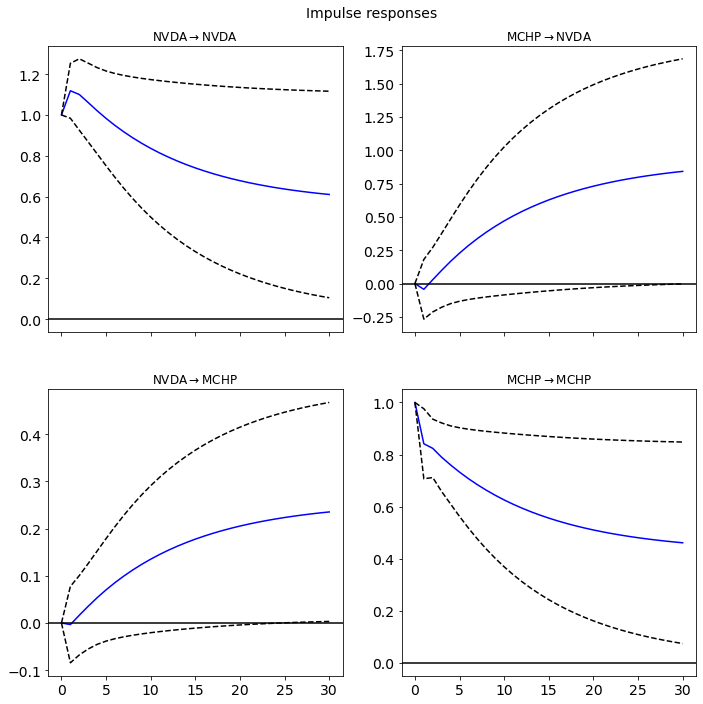

In [ ]:
num_periods = 30
ir = model.irf(periods=num_periods)
ir.plot(plot_stderr=True)
plt.show()

## Bayesian VAR(1)

### Data Prep

In [ ]:
y=macro_df[['gdpyoy','infl','unemp','10yr']].copy().dropna()
train_y=y[:-18]
test_y=y[-18:]

### Visualization

In [ ]:
from matplotlib.colors import ColorConverter
colors = ("C0", "C1","C2","C3")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
    "C2": tuple(c * .35 for c in (ColorConverter.to_rgb("C2"))),
    "C3": tuple(c * .35 for c in (ColorConverter.to_rgb("C3"))),

}

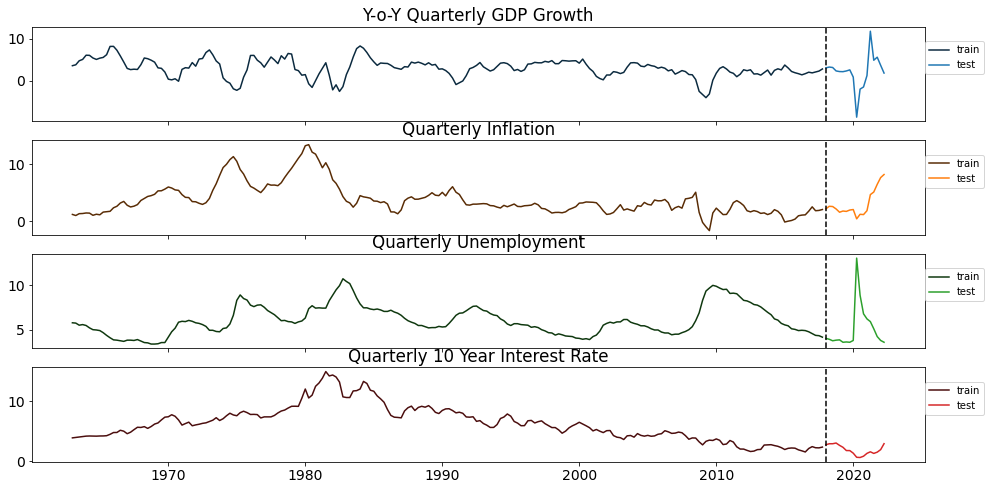

In [ ]:
_, ax = plt.subplots(4, 1, figsize=(16, 8), sharex=True)
ax[0].plot(train_y["gdpyoy"], color=dark["C0"], label="train")
ax[0].plot(test_y["gdpyoy"], color="C0", label="test")
# ax[0].set_ylabel("Y-o-Y Quarterly Growth", fontsize=10)
ax[0].set_title("Y-o-Y Quarterly GDP Growth")

ax[1].plot(train_y["infl"], color=dark["C1"], label="train")
ax[1].plot(test_y["infl"], color="C1", label="test")
# ax[1].set_ylabel("", fontsize=10)
ax[1].set_title("Quarterly Inflation")

ax[2].plot(train_y["unemp"], color=dark["C2"], label="train")
ax[2].plot(test_y["unemp"], color="C2", label="test")
# ax[0].set_ylabel("Y-o-Y Quarterly Growth", fontsize=10)
ax[2].set_title("Quarterly Unemployment")

ax[3].plot(train_y["10yr"], color=dark["C3"], label="train")
ax[3].plot(test_y["10yr"], color="C3", label="test")
# ax[1].set_ylabel("", fontsize=10)
ax[3].set_title("Quarterly 10 Year Interest Rate")


for axi in ax:
    axi.axvline(y.index[-18], ls="--", color="k")
    axi.legend(loc=(1, 0.5), fontsize=10)

### Implementing the Model

In [ ]:
lags = 1

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": ("gdpyoy", "infl",'unemp','10yr'),
    "cross_vars": ("gdpyoy", "infl",'unemp','10yr'),
    "time": range(len(train_y) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_GDPGrowth = pm.math.sum([
        pm.math.sum(lag_coefs[i, 0] * train_y.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)        
    ar_Infl = pm.math.sum([
        pm.math.sum(lag_coefs[i, 1] * train_y.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)   
    
    ar_Unemp = pm.math.sum([
        pm.math.sum(lag_coefs[i, 2] * train_y.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)   

    ar_10yr = pm.math.sum([
        pm.math.sum(lag_coefs[i, 3] * train_y.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)   



    # Stack autoregressive terms and add intercepts
    mean = intercept + pm.math.stack([ar_GDPGrowth,ar_Infl,ar_Unemp, ar_10yr], axis=-1)

    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=train_y[lags:], dims=("time", "vars"))

In [ ]:
seed = 2001
rng = np.random.default_rng(seed=seed)

In [ ]:
with BVAR_model:
    trace = pm.sample(chains=4, random_seed=rng)

In [ ]:
import arviz as az

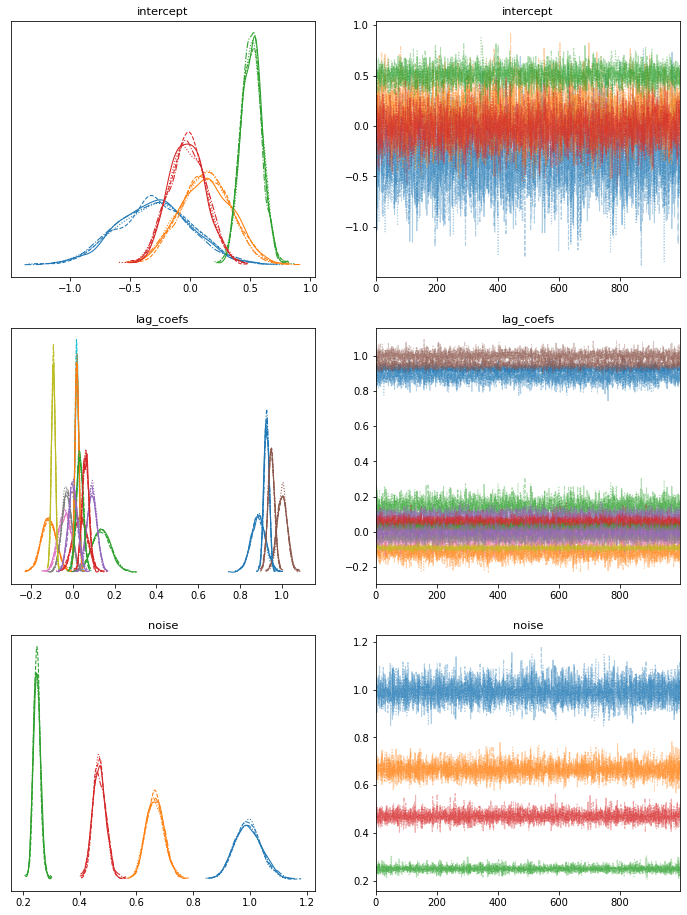

In [ ]:
az.plot_trace(trace,figsize=(12, 16));

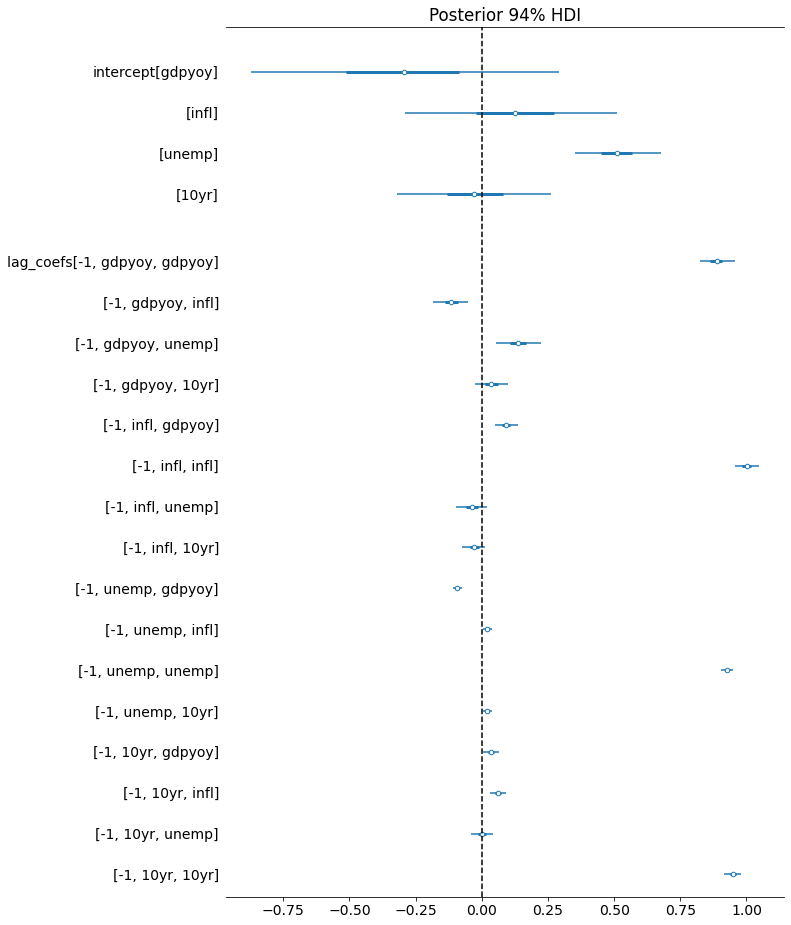

In [ ]:
az.plot_forest(trace, var_names=["intercept", "lag_coefs"], combined=True, textsize=14,figsize=(10, 16))
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI");

In [ ]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=18):
    len_data = len(train_y)
    new_draws = np.zeros((train_y.shape[0]+forecast, train_y.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = train_y[:]
    for i in range(forecast):
        ar_GDPGrowth = np.sum(lag_coefs[:, 0] * new_draws[len_data+i-lags: len_data+i])
        ar_Infl=np.sum(lag_coefs[:, 1] * new_draws[len_data+i-lags: len_data+i])
        ar_Unemp=np.sum(lag_coefs[:, 2] * new_draws[len_data+i-lags: len_data+i])
        ar_10yr = np.sum(lag_coefs[:, 3] * new_draws[len_data+i-lags: len_data+i])
        mean = intercept + np.stack([ar_GDPGrowth,ar_Infl, ar_Unemp,ar_10yr])
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [ ]:
# Take a random subset of 100 draws from the posterior
draws = rng.integers(4000, size=100)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["intercept"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape

((100, 4), (100, 1, 4, 4), (100, 4))

In [ ]:
# Forecast 18 quarters into the future
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=18)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)

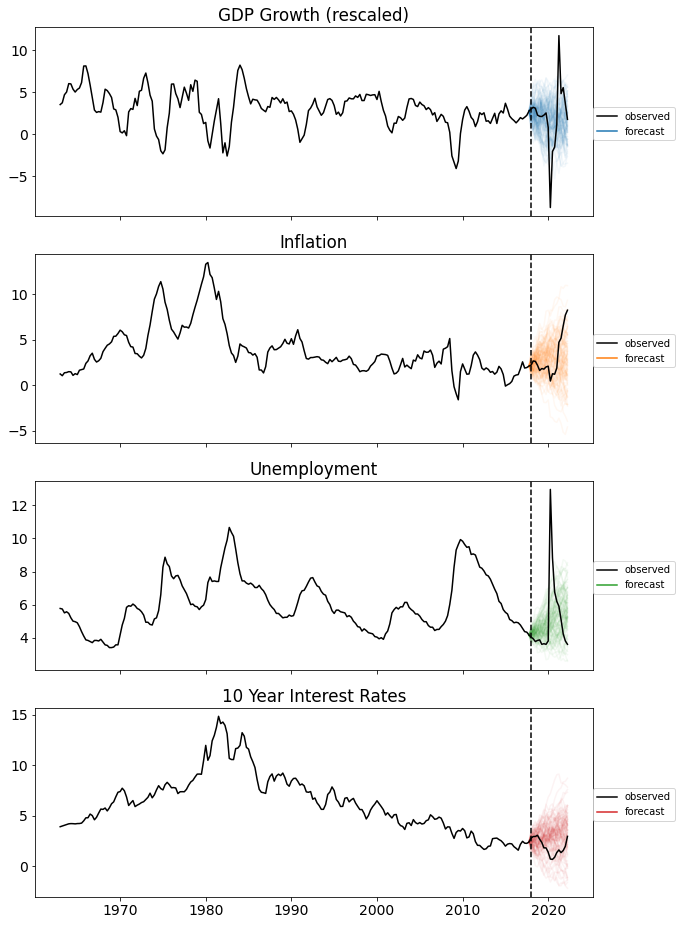

In [ ]:
_, ax = plt.subplots(4, 1, sharex=True,figsize=(10, 16))

ax[0].set_title("GDP Growth (rescaled)")
ax[0].plot(y.index, ppc_draws[..., 0], color="C0", alpha=0.05)
ax[0].plot(y["gdpyoy"], color="k", label="observed")
ax[0].plot([], color="C0", label="forecast")

ax[1].set_title("Inflation")
ax[1].plot(y.index, ppc_draws[..., 1], color="C1", alpha=0.05)
ax[1].plot(y["infl"], color="k", label="observed")
ax[1].plot([], color="C1", label="forecast")

ax[2].set_title("Unemployment")
ax[2].plot(y.index, ppc_draws[..., 2], color="C2", alpha=0.05)
ax[2].plot(y["unemp"], color="k", label="observed")
ax[2].plot([], color="C2", label="forecast")


ax[3].set_title("10 Year Interest Rates")
ax[3].plot(y.index, ppc_draws[..., 3], color="C3", alpha=0.05)
ax[3].plot(y["10yr"], color="k", label="observed")
ax[3].plot([], color="C3", label="forecast")


for axi in ax:
    axi.axvline(test_y.index[0], ls="--", color="k")
    axi.legend(fontsize=10, loc=(1, .4))
    # axi.set_ylabel("quartely change", fontsize=12)

## TVP-VAR(2) - Bayesian Analysis

In [ ]:
# 1. Create a new TVPVAR class as a subclass of sm.tsa.statespace.MLEModel
class TVPVAR(sm.tsa.statespace.MLEModel):
    # Steps 2-3 are best done in the class "constructor", i.e. the __init__ method
    def __init__(self, y,lag):
        # Create a matrix with [y_t' : y_{t-1}'] for t = 2, ..., T
        augmented = sm.tsa.lagmat(y, lag, trim='both', original='in', use_pandas=True)
        # Separate into y_t and z_t = [1 : y_{t-1}']
        p = y.shape[1]
        y_t = augmented.iloc[:, :p]
        z_t = sm.add_constant(augmented.iloc[:, p:])

        # Recall that the length of the state vector is p * (p + 1)
        k_states = p * (lag*p + 1)
        super().__init__(y_t, exog=z_t, k_states=k_states)

        # Note that the state space system matrices default to contain zeros,
        # so we don't need to explicitly set c_t = d_t = 0.

        # Construct the design matrix Z_t
        # Notes:
        # -> self.k_endog = p is the dimension of the observed vector
        # -> self.k_states = p * (p + 1) is the dimension of the observed vector
        # -> self.nobs = T is the number of observations in y_t
        self['design'] = np.zeros((self.k_endog, self.k_states, self.nobs))
        for i in range(self.k_endog):
            start = i * (lag*self.k_endog + 1)
            end = start + lag*self.k_endog + 1
            self['design', i, start:end, :] = z_t.T

        # Construct the transition matrix T = I
        self['transition'] = np.eye(k_states)

        # Construct the selection matrix R = I
        self['selection'] = np.eye(k_states)

        # Step 3: Initialize the state vector as alpha_1 ~ N(0, 5I)
        self.ssm.initialize('known', stationary_cov=(1+p*lag) * np.eye(self.k_states))

    # Step 4. Create a method that we can call to update H and Q
    def update_variances(self, obs_cov, state_cov_diag):
        self['obs_cov'] = obs_cov
        self['state_cov'] = np.diag(state_cov_diag)

    # Finally, it can be convenient to define human-readable names for
    # each element of the state vector. These will be available in output
    @property
    def state_names(self):

        state_names = np.empty((self.k_endog, int(self.k_states/self.k_endog)), dtype=object)
        for i in range(self.k_endog):
            endog_name = self.endog_names[i]
            state_names[i] = (
                ['intercept.%s' % endog_name] +
                ['L1.%s->%s' % (other_name, endog_name) for other_name in self.endog_names]+
                ['L2.%s->%s' % (other_name, endog_name) for other_name in self.endog_names])
        return state_names.ravel().tolist()

In [ ]:
y=macro_df[['gdpyoy','infl','unemp','10yr']].copy()

In [ ]:
mod = TVPVAR(y,2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In our analysis below, we will need to begin our MCMC iterations with some initial parameterization. Following Chan and Jeliazkov (2009) we will set 
H
 to be the sample covariance matrix of our dataset, and we will set 
$$\sigma_i^2=0.01 \ \forall i$$

Before discussing the MCMC scheme that will allow us to make inferences about the model, first we can consider the output of the model when simply plugging in these initial parameters. To fill in these parameters, we use the update_variances method that we defined earlier and then perform Kalman filtering and smoothing conditional on those parameters.

In [ ]:
initial_obs_cov = np.cov(y.T)
initial_state_cov_diag = [0.01] * mod.k_states

# Update H and Q
mod.update_variances(initial_obs_cov, initial_state_cov_diag)

# Perform Kalman filtering and smoothing
# (the [] is just an empty list that in some models might contain
# additional parameters. Here, we don't have any additional parameters
# so we just pass an empty list)
initial_res = mod.smooth([])

The 'initial_res' variable contains the output of Kalman filtering and smoothing, conditional on those initial parameters. In particular, we may be interested in the “smoothed states”, which are 
$$E[\alpha_t |y^t,H,\lbrace\sigma_i^2 \rbrace] $$

First, lets create a function that graphs the coefficients over time, separated into the equations for equation of the observed variables.

In [ ]:
def plot_coefficients_by_equation(states):
    fig, axes = plt.subplots(4, figsize=(10, 16))

    # The way we defined Z_t implies that the first 5 elements of the
    # state vector correspond to the first variable in y_t, which is GDP growth
    ax = axes[0]
    states.iloc[:, :9].plot(ax=ax)
    ax.set_title('GDP growth')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # The next 5 elements correspond to inflation
    ax = axes[1]
    states.iloc[:, 9:18].plot(ax=ax)
    ax.set_title('Inflation rate')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

    # The next 5 elements correspond to unemployment
    ax = axes[2]
    states.iloc[:, 18:27].plot(ax=ax)
    ax.set_title('Unemployment equation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # The last 5 elements correspond to the interest rate
    ax = axes[3]
    states.iloc[:, 27:36].plot(ax=ax)
    ax.set_title('Interest rate equation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

    return ax

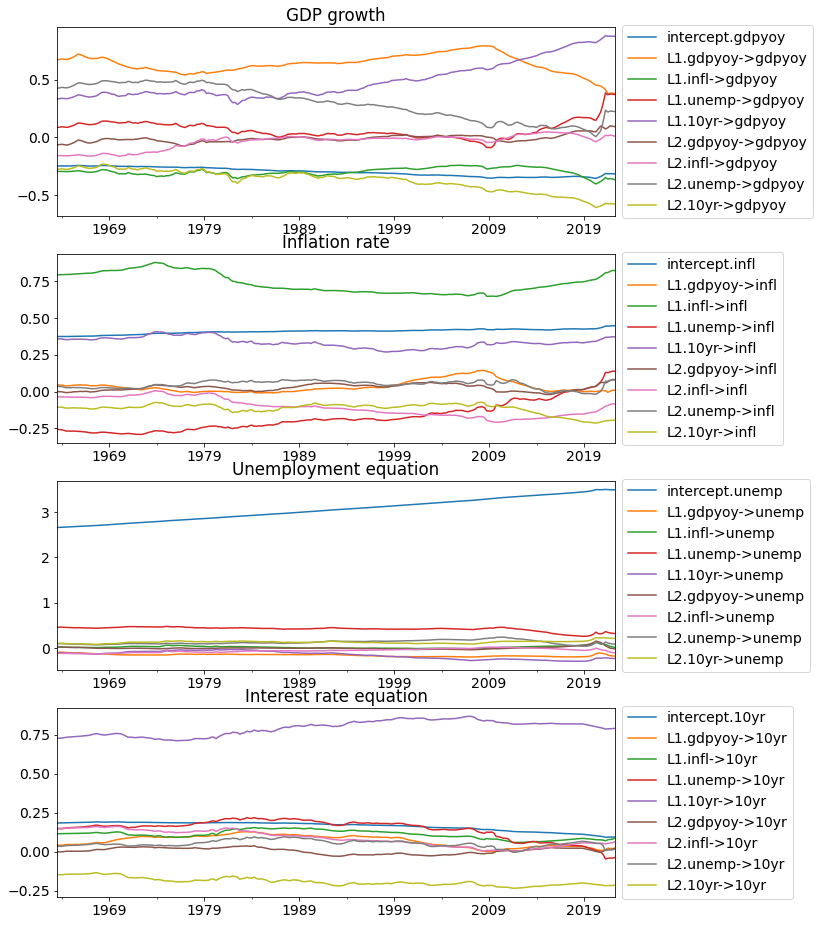

In [ ]:
# Here, for illustration purposes only, we plot the time-varying
# coefficients conditional on an ad-hoc parameterization

# Recall that `initial_res` contains the Kalman filtering and smoothing,
# and the `states.smoothed` attribute contains the smoothed states
plot_coefficients_by_equation(initial_res.states.smoothed);

Let's now implement the Gibbs sampler.
Conditional Conjugate priors:
$$H\sim IW(v_1^0,S_1^0)$$
$$ \sigma_{i}^{2} \sim IG \left( \frac{v_{i,2}^{0}}{2},\frac{S_{i,2}^{0}}{2}\right)$$

In [ ]:

# Prior hyperparameters

# Prior for obs. cov. is inverse-Wishart(v_1^0=k + 3, S10=I)
v10 = mod.k_endog + 3
S10 = np.eye(mod.k_endog)

# Prior for state cov. variances is inverse-Gamma(v_{i2}^0 / 2 = 3, S+{i2}^0 / 2 = 0.005)
vi20 = 6
Si20 = 0.01

In [ ]:
# Gibbs sampler setup
niter = 1000
nburn = 10

# 1. Create storage arrays
store_states = np.zeros((niter + 1, mod.nobs, mod.k_states))
store_obs_cov = np.zeros((niter + 1, mod.k_endog, mod.k_endog))
store_state_cov = np.zeros((niter + 1, mod.k_states))

# 2. Put in the initial values
store_obs_cov[0] = initial_obs_cov
store_state_cov[0] = initial_state_cov_diag
mod.update_variances(store_obs_cov[0], store_state_cov[0])

# 3. Construct posterior samplers
sim = mod.simulation_smoother(method='kfs')

In [ ]:
for i in range(niter):
    mod.update_variances(store_obs_cov[i], store_state_cov[i])
    sim.simulate()

    # 1. Sample states
    store_states[i + 1] = sim.simulated_state.T

    # 2. Simulate obs cov
    fitted = np.matmul(mod['design'].transpose(2, 0, 1), store_states[i + 1][..., None])[..., 0]
    resid = mod.endog - fitted
    store_obs_cov[i + 1] = invwishart.rvs(v10 + mod.nobs, S10 + resid.T @ resid)

    # 3. Simulate state cov variances
    resid = store_states[i + 1, 1:] - store_states[i + 1, :-1]
    sse = np.sum(resid**2, axis=0)

    for j in range(mod.k_states):
        rv = invgamma.rvs((vi20 + mod.nobs - 1) / 2, scale=(Si20 + sse[j]) / 2)
        store_state_cov[i + 1, j] = rv

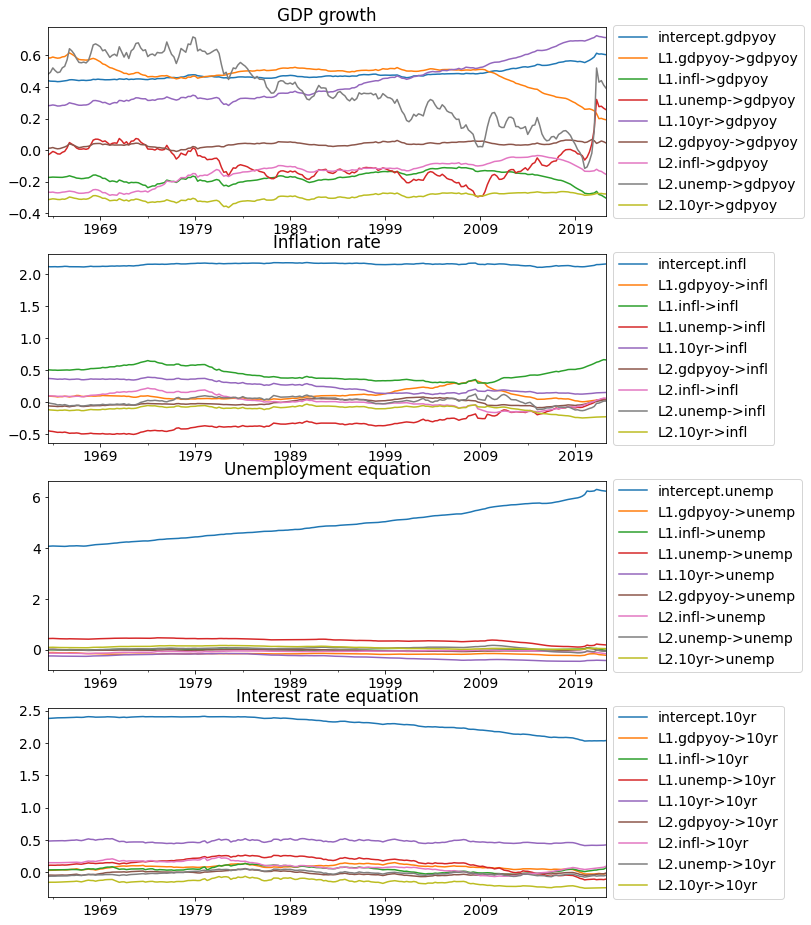

In [ ]:
# Collect the posterior means of each time-varying coefficient
states_posterior_mean = pd.DataFrame(
    np.mean(store_states[nburn + 1:], axis=0),
    index=mod._index, columns=mod.state_names)

# Plot these means over time
plot_coefficients_by_equation(states_posterior_mean);

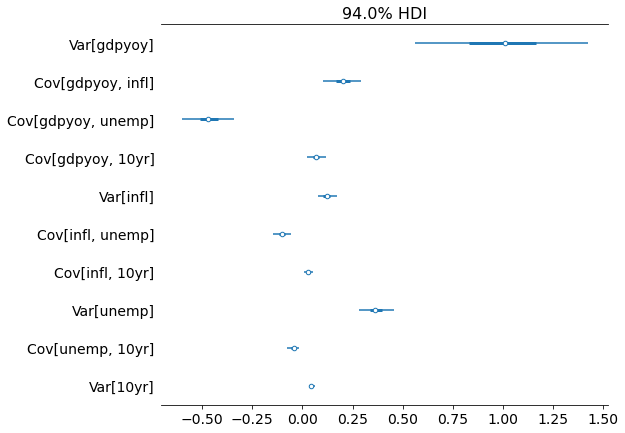

In [ ]:
import arviz as az

# Collect the observation error covariance parameters
az_obs_cov = az.convert_to_inference_data({
    ('Var[%s]' % mod.endog_names[i] if i == j else
     'Cov[%s, %s]' % (mod.endog_names[i], mod.endog_names[j])):
    store_obs_cov[nburn + 1:, i, j]
    for i in range(mod.k_endog) for j in range(i, mod.k_endog)})

# Plot the credible intervals
az.plot_forest(az_obs_cov, figsize=(8, 7));

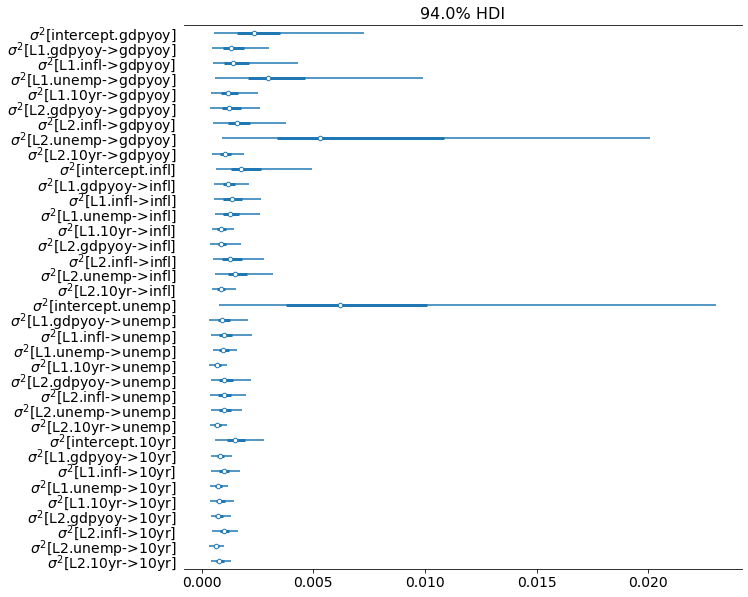

In [ ]:
# Collect the state innovation variance parameters
az_state_cov = az.convert_to_inference_data({
    r'$\sigma^2$[%s]' % mod.state_names[i]: store_state_cov[nburn + 1:, i]
    for i in range(mod.k_states)})

# Plot the credible intervals
az.plot_forest(az_state_cov, figsize=(10, 10));

## Principal Component Analysis

## Get the Data

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/MGTF 405/inflation.xlsx',parse_dates=True, index_col=0)

df=df.dropna()

After cleaning the data from missing observations, our sample starts from March 1992. We have 363 observations per variable.


## First 8 Factors of Fred-MD Data

In the first case we will get 8 factors from the full dataset, meaning that we will treat the full list of variables as one matrix.

In [ ]:
pca_model = PCA(df, standardize=False, demean=True)

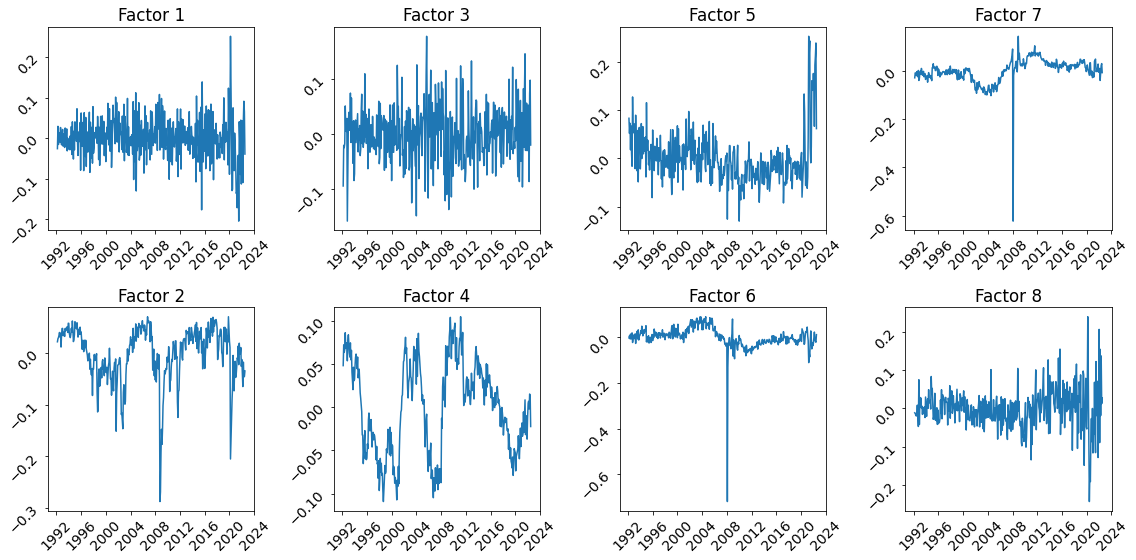

In [ ]:
fig, axs = plt.subplots(2, 4)
axs[0, 0].plot(pca_model.factors.iloc[:,0])
axs[0, 0].set_title("Factor 1")
axs[0,0].tick_params(labelrotation=45)

axs[1, 0].plot(pca_model.factors.iloc[:,1])
axs[1, 0].set_title("Factor 2")
axs[1,0].tick_params(labelrotation=45)


axs[0, 1].plot(pca_model.factors.iloc[:,2])
axs[0, 1].set_title("Factor 3")
axs[0,1].tick_params(labelrotation=45)


axs[1, 1].plot(pca_model.factors.iloc[:,3])
axs[1, 1].set_title("Factor 4")
axs[1,1].tick_params(labelrotation=45)

axs[0, 2].plot(pca_model.factors.iloc[:,4])
axs[0, 2].set_title("Factor 5")
axs[0,2].tick_params(labelrotation=45)


axs[1, 2].plot(pca_model.factors.iloc[:,5])
axs[1, 2].set_title("Factor 6")
axs[1,2].tick_params(labelrotation=45)

axs[0, 3].plot(pca_model.factors.iloc[:,6])
axs[0, 3].set_title("Factor 7")
axs[0,3].tick_params(labelrotation=45)

axs[1, 3].plot(pca_model.factors.iloc[:,7])
axs[1, 3].set_title("Factor 8")
axs[1,3].tick_params(labelrotation=45)

fig.tight_layout()

## Getting Factors by Group

 Get the grouping definition from the online appendix

### Get the Groupings

In [ ]:
defn = pd.read_excel('/content/drive/MyDrive/MGTF 405/fredmd_def.xlsx')

In [ ]:
groups = defn[['fred','group']].copy()
columns = [name for name in defn['fred'] if name in df.columns]
df = df.reindex(columns,axis=1)

### Create 8 Subset of the Data based on Groups

In [ ]:
df_1 = df.iloc[:,:16]
df_2 = df.iloc[:,16:47]
df_3= df.iloc[:,47:57]
df_4 = df.iloc[:,57:67]
df_5 = df.iloc[:,67:80]
df_6 = df.iloc[:,80:102]
df_7 = df.iloc[:,102:122]
df_8 = df.iloc[:,122:127]

In [ ]:
df_1

,RPI,W875RX1,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPFUELS,CUMFNS,HWI
Date,,,,,,,,,,,,,,,,
1992-03-01,0.001653,0.000812,0.008279,0.008512,0.008994,0.009106,0.020378,0.005180,0.011745,0.007989,0.011295,0.014042,0.010142,0.004800,0.6213,140.0
1992-04-01,0.003730,0.002751,0.007593,0.007433,0.007599,0.009344,0.018507,0.006125,0.009584,0.007794,0.006522,0.001707,0.005383,0.006028,0.2372,-104.0
1992-05-01,0.005329,0.005493,0.003221,0.005498,0.005804,0.006482,0.030804,-0.002189,0.007925,0.000352,0.010441,-0.004866,0.005787,-0.008540,0.2628,94.0
1992-06-01,0.004173,0.004447,0.000539,-0.002438,-0.003092,-0.004904,-0.013822,-0.001717,0.002472,0.004296,0.002106,0.010879,0.003273,-0.003832,0.0569,-36.0
1992-07-01,-0.000796,-0.001346,0.008911,0.009982,0.011293,0.012977,0.025699,0.008433,0.010158,0.007562,0.011178,0.000204,0.008899,0.003289,0.5077,-20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,-0.003316,-0.002862,0.007003,0.003294,0.004622,0.002046,0.029312,-0.006065,0.011939,0.011096,0.005860,0.001718,0.007732,0.012438,0.5505,511.0
2022-04-01,0.002163,0.002945,0.006545,0.010177,0.013053,0.012940,0.022151,0.010143,0.009550,0.002574,0.009832,0.000983,0.004341,-0.021275,0.2773,-174.0
2022-05-01,0.000014,0.001228,-0.000881,-0.003991,-0.005663,-0.007910,-0.029132,-0.001539,-0.002679,0.002487,-0.009079,-0.001648,-0.003780,0.004570,-0.3744,-378.0


### Run PCA

In [ ]:
pca_model_g1 = PCA(df_1, standardize=False, demean=True)
pca_model_g2 = PCA(df_2, standardize=False, demean=True)
pca_model_g3 = PCA(df_3, standardize=False, demean=True)
pca_model_g4 = PCA(df_4, standardize=False, demean=True)
pca_model_g5 = PCA(df_5, standardize=False, demean=True)
pca_model_g6 = PCA(df_6, standardize=False, demean=True)
pca_model_g7 = PCA(df_7, standardize=False, demean=True)
pca_model_g8 = PCA(df_8, standardize=False, demean=True)

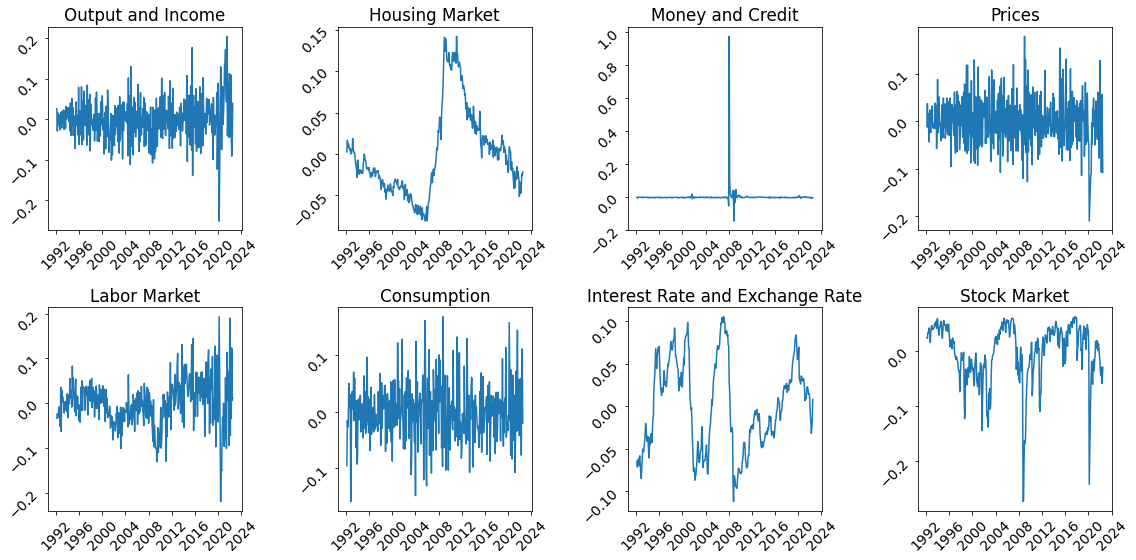

In [ ]:
fig, axs = plt.subplots(2, 4)
axs[0, 0].plot(pca_model_g1.factors.iloc[:,0])
axs[0, 0].set_title("Output and Income")
axs[0,0].tick_params(labelrotation=45)

axs[1, 0].plot(pca_model_g2.factors.iloc[:,0])
axs[1, 0].set_title("Labor Market")
axs[1,0].tick_params(labelrotation=45)


axs[0, 1].plot(pca_model_g3.factors.iloc[:,0])
axs[0, 1].set_title("Housing Market")
axs[0,1].tick_params(labelrotation=45)


axs[1, 1].plot(pca_model_g4.factors.iloc[:,0])
axs[1, 1].set_title("Consumption")
axs[1,1].tick_params(labelrotation=45)

axs[0, 2].plot(pca_model_g5.factors.iloc[:,0])
axs[0, 2].set_title("Money and Credit")
axs[0,2].tick_params(labelrotation=45)


axs[1, 2].plot(pca_model_g6.factors.iloc[:,0])
axs[1, 2].set_title("Interest Rate and Exchange Rate")
axs[1,2].tick_params(labelrotation=45)

axs[0, 3].plot(pca_model_g7.factors.iloc[:,0])
axs[0, 3].set_title("Prices")
axs[0,3].tick_params(labelrotation=45)

axs[1, 3].plot(pca_model_g8.factors.iloc[:,0])
axs[1, 3].set_title("Stock Market")
axs[1,3].tick_params(labelrotation=45)

fig.tight_layout()